# Qual é o filo?

## Informações do Autor

Erick Melo Vidal de Oliveira - 190027355

## Objetivo

O modelo a seguir tem como objetivo identificar o filo ao qual um determinado animal pertence

## 1. Baixando imagens de cada filo

Para iniciar o processo, é necessária a intalação e importação de alguns pacotes e bibliotecas que serão utilizadas durante o projeto, sendo a FastAI e a DuckDuckGo as principais.

In [45]:
# Primeiramente deve ser feita a instalação do fastai para a criação e modelagem do problema
# e do duckduckgo_search para pesquisar o url das imagens desejadas.
!pip install -Uqq fastai duckduckgo_search

# Em seguida, importar os pacotes que serão utilizados.
import os
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

Com os recursos importados, agora é possível criar a função que irá fazer a busca das imagens e armazená-las em uma pasta de cada um dos 9 filos que existem, sendo eles:
* poríferos;
* cnidários;
* platelmintos;
* nematelmintos;
* moluscos;
* anelídeos;
* artrópodes;
* equinodermos;
* cordados.

In [46]:
# Essa função irá receber um term que será pesquisado e um número máximo de imagens para 
# ser pesquisado, pré-definido como 100.
def pesquisar_imagem(term, max_images=60):
    print(f"Pesquisando por '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Como a pesquisa simples dos nomes de cada filo irá retornar imagens de tabelas e gráficos que mostram a classificação taxonômica completa, foi necessário adicionar algumas flags como `-classification -groups -phylogeny` na pesquisa para reduzir as chances de aparecerem essas imagens indesejadas.

In [47]:
# Nome dos filos
searches = 'porifera','cnidaria','plathelminthes','nematoda','mollusca','annelida','arthropoda','echinodermata','chordata'
path = Path('encontra_filo')

# Loop que irá pesquisar imagens de cada filo
for filo in searches:
    dest = (path/filo)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=pesquisar_imagem(f'{filo} animals -classification -groups -phylogeny'))
    resize_images(path/filo, max_size=400, dest=path/filo)

Pesquisando por 'porifera animals -classification -groups -phylogeny'
Pesquisando por 'cnidaria animals -classification -groups -phylogeny'
Pesquisando por 'plathelminthes animals -classification -groups -phylogeny'
Pesquisando por 'nematoda animals -classification -groups -phylogeny'
Pesquisando por 'mollusca animals -classification -groups -phylogeny'
Pesquisando por 'annelida animals -classification -groups -phylogeny'
Pesquisando por 'arthropoda animals -classification -groups -phylogeny'
Pesquisando por 'echinodermata animals -classification -groups -phylogeny'
Pesquisando por 'chordata animals -classification -groups -phylogeny'


## 2. Treinando o modelo

Com as imagens já baixadas, agora é possível utilizá-las para treinar o modelo. Porém, ainda existe a possibilidade de algumas imagens baixadas estarem com erro. Portanto, é necessário excluir essas imagens para o modelo não utilizá-las como parâmetro para aprender.

In [48]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

Após excluir as imagens defeituosas, será criado o DataLoader, que é um objeto que contém um modelo de treino (as imagens baixadas) e uma validação de imagens para checar a acurácia do modelo. Com o FastAI é possível fazer isso de maneira bem simples e exibir algumas imagens encontradas utilizando o DataBlock, que utiliza alguns parâmetros para melhorar o treino, sendo eles:
* `blocks=(ImageBlock, CategoryBlock),` define o Input (imagem baixada) e o Output (categoria de cada imagem) do bloco.
* `get_items=get_image_files,` retorna a lista de todas as imagens baixadas
* `splitter=RandomSplitter(valid_pct=0.2, seed=42),` divide os dados entre treinamente e validação aleatoriamente, utilizando 20% dos dados para o conjunto de validação
* `get_y=parent_label,` recupera a cadegoria de cada imagem baixada, nesse caso, o nome de cada filo
* `item_tfms=[Resize(192, method='squish')]` define o tamanho da imagem para 192x192 pixels


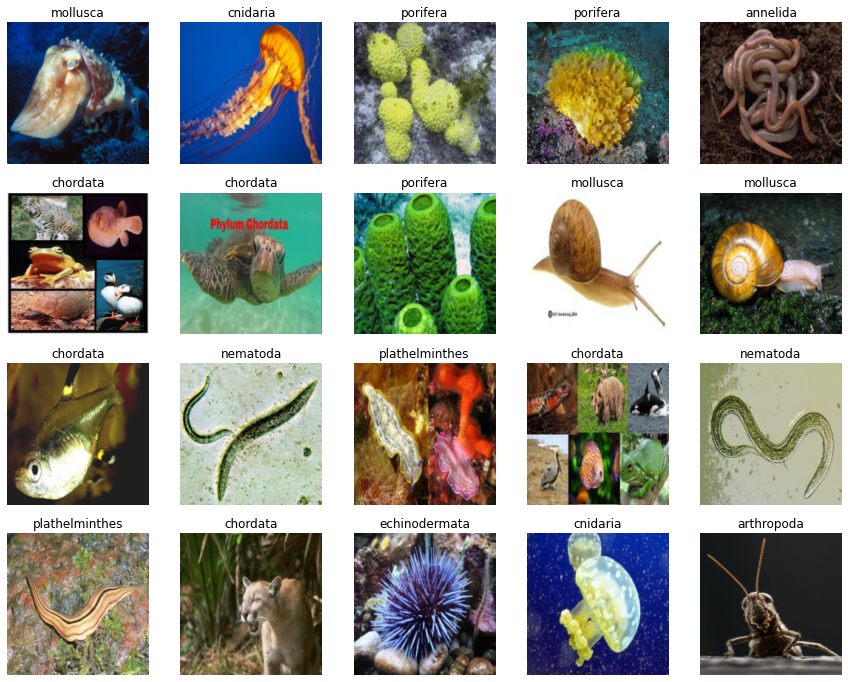

In [49]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=20)

Agora os parâmetros definidos podem ser utilizados para treinar o modelo, e para isso, será utilizado o modelo resnet18, que consiste em uma rede neural com capacidade de aprender representações para uma ampla variedade de imagens.

Para auxiliar esse aprendizado, será utilizado o método `fine_tune()` da FastAI, que utiliza as melhores práticas para melhorar um modelo pré-treinado, nesse caso o resnet18.

In [50]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(50)

epoch,train_loss,valid_loss,error_rate,time
0,1.471742,0.526308,0.118738,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.427142,0.256959,0.072356,00:14
1,0.254472,0.195141,0.042672,00:14
2,0.165264,0.152228,0.029685,00:13
3,0.105106,0.165384,0.038961,00:13
4,0.084161,0.181975,0.031540,00:14
5,0.071081,0.179141,0.029685,00:13
6,0.074759,0.178915,0.035250,00:14
7,0.066558,0.150407,0.033395,00:14
8,0.059657,0.187163,0.027829,00:14
9,0.072233,0.145737,0.027829,00:13


Nos primeiros testes realizados, foram utilizados os valores de 10, 20, 30 e 40 como parâmetro para o `fine_tune()`, porém com esses valores o modelo ainda encontrava dificuldades para diferenciar animais dos filos nematelmintos, anelídeos e moluscos, que realmente são semelhantes. Porém, utilizando 50 como parâmeto para esse método, o modelo conseguiu classificar os animais de maneira mais acertiva e, por isso, o valor foi mantido.

## 3: Utilizando o modelo

A seguir, foi realizada uma pesquisa para cada um dos filos citados anteriormente, utilizando os seguintes animais para representar cada filo respectivamente:
* Esponja Marinha
* Água Viva
* Planária
* Lombriga
* Ostra
* Minhoca
* Aranha
* Estrela do Mar
* Gato

Pesquisando por 'Esponja Marinha'


Isso é um: porifera.
A probabilidade de ser um porifera é: 1.0000


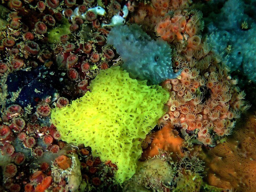

In [61]:
urls = pesquisar_imagem('Esponja Marinha', max_images=1)
image = 'animal.jpg'
download_url(urls[0], image, show_progress=False)

filo,_,probs = learn.predict(PILImage.create('animal.jpg'))
print(f"Isso é um: {filo}.")
print(f"A probabilidade de ser um {filo} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Água Viva'


Isso é um: cnidaria.
A probabilidade de ser um cnidaria é: 1.0000


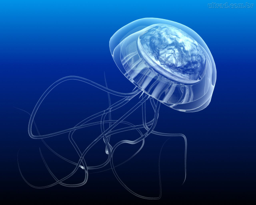

In [53]:
urls = pesquisar_imagem('Água Viva', max_images=1)
image = 'animal.jpg'
download_url(urls[0], image, show_progress=False)

filo,_,probs = learn.predict(PILImage.create('animal.jpg'))
print(f"Isso é um: {filo}.")
print(f"A probabilidade de ser um {filo} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Planária'


Isso é um: plathelminthes.
A probabilidade de ser um plathelminthes é: 0.8668


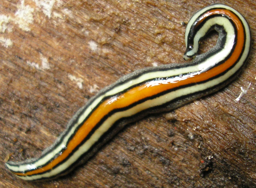

In [54]:
urls = pesquisar_imagem('Planária', max_images=1)
image = 'animal.jpg'
download_url(urls[0], image, show_progress=False)

filo,_,probs = learn.predict(PILImage.create('animal.jpg'))
print(f"Isso é um: {filo}.")
print(f"A probabilidade de ser um {filo} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Lombriga'


Isso é um: nematoda.
A probabilidade de ser um nematoda é: 1.0000


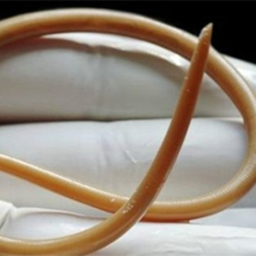

In [55]:
urls = pesquisar_imagem('Lombriga', max_images=1)
image = 'animal.jpg'
download_url(urls[0], image, show_progress=False)

filo,_,probs = learn.predict(PILImage.create('animal.jpg'))
print(f"Isso é um: {filo}.")
print(f"A probabilidade de ser um {filo} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Ostra'


Isso é um: mollusca.
A probabilidade de ser um mollusca é: 1.0000


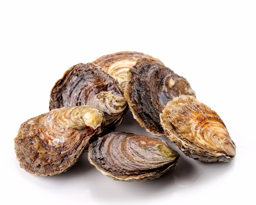

In [56]:
urls = pesquisar_imagem('Ostra', max_images=1)
image = 'animal.jpg'
download_url(urls[0], image, show_progress=False)

filo,_,probs = learn.predict(PILImage.create('animal.jpg'))
print(f"Isso é um: {filo}.")
print(f"A probabilidade de ser um {filo} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Minhoca'


Isso é um: annelida.
A probabilidade de ser um annelida é: 0.9983


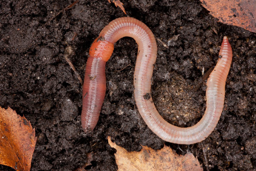

In [57]:
urls = pesquisar_imagem('Minhoca', max_images=1)
image = 'animal.jpg'
download_url(urls[0], image, show_progress=False)

filo,_,probs = learn.predict(PILImage.create('animal.jpg'))
print(f"Isso é um: {filo}.")
print(f"A probabilidade de ser um {filo} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Aranha'


Isso é um: arthropoda.
A probabilidade de ser um arthropoda é: 0.9999


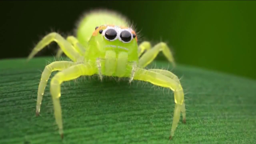

In [58]:
urls = pesquisar_imagem('Aranha', max_images=1)
image = 'animal.jpg'
download_url(urls[0], image, show_progress=False)

filo,_,probs = learn.predict(PILImage.create('animal.jpg'))
print(f"Isso é um: {filo}.")
print(f"A probabilidade de ser um {filo} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Estrela do Mar'


Isso é um: echinodermata.
A probabilidade de ser um echinodermata é: 1.0000


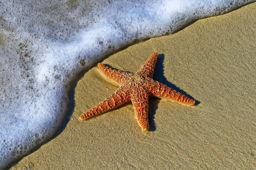

In [59]:
urls = pesquisar_imagem('Estrela do Mar', max_images=1)
image = 'animal.jpg'
download_url(urls[0], image, show_progress=False)

filo,_,probs = learn.predict(PILImage.create('animal.jpg'))
print(f"Isso é um: {filo}.")
print(f"A probabilidade de ser um {filo} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Gato'


Isso é um: chordata.
A probabilidade de ser um chordata é: 0.9999


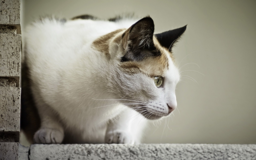

In [60]:
urls = pesquisar_imagem('Gato', max_images=1)
image = 'animal.jpg'
download_url(urls[0], image, show_progress=False)

filo,_,probs = learn.predict(PILImage.create('animal.jpg'))
print(f"Isso é um: {filo}.")
print(f"A probabilidade de ser um {filo} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)